In [1]:
%pip install langchain langgraph langchain-ollama


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from typing import TypedDict, List
from langchain_ollama import ChatOllama
import re

llm = ChatOllama(model="llama3.2:3b", temperature=0)

task_logs_key = "logs"

class ScrumState(TypedDict):
    task: str
    logs: List[str]
    pi_table: str

def clean_log(text: str) -> str:
    return re.sub(r"^(Certainly!?|Sure!?|Of course!?)\s*(Below is|Here('s| is)).*?:?\s*", "", text, flags=re.IGNORECASE).strip()


In [3]:
def customer_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"You are the Grocery Store Manager commissioning a new dashboard app. "
        f"Your task: '{state['task']}'.\n\n"
        "Please provide your requirements:\n"
        "1. Business Goals & Success Metrics\n"
        "2. Primary User Scenarios\n"
        "3. Functional Requirements & Acceptance Criteria\n"
        "4. Data Sources & Integrations\n"
        "5. Prioritization (Must-have vs. Nice-to-have)"
    )
    response = llm.invoke(prompt).content
    state[task_logs_key].append(f"[Customer]: {response}")
    return state

def project_manager_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"You are the Project Manager. Task: '{state['task']}'.\n"
        "Provide:\n"
        "1. Business Objectives & KPIs\n"
        "2. Scope Definition\n"
        "3. Work Breakdown Structure\n"
        "4. Milestones & Timeline Estimates\n"
        "5. Resource & Role Assignments\n"
        "6. Dependencies & Risks\n"
        "7. Communication Plan"
    )
    response = llm.invoke(prompt).content
    state[task_logs_key].append(f"[Project Manager]: {response}")
    return state

def analyst_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"You are the Business Analyst. Task: '{state['task']}'.\n"
        "Provide analysis:\n"
        "1. Bridging the Gap\n"
        "2. Data Analysis & Interpretation\n"
        "3. Process Improvement\n"
        "4. Requirements Documentation\n"
        "5. Solution Design & Feasibility\n"
        "6. Stakeholder Communication\n"
        "7. Risks & Mitigations\n"
        "8. Effort & Impact Estimation"
    )
    response = llm.invoke(prompt).content
    state[task_logs_key].append(f"[Business Analyst]: {response}")
    return state

def designer_node(state: ScrumState) -> ScrumState:
    ba = "\n".join(log for log in state[task_logs_key] if log.startswith("[Business Analyst]"))
    prompt = (
        f"You are the UI/UX Designer. Task: '{state['task']}'.\n\n"
        f"Refer to this analysis:\n{ba}\n\n"
        "Design Plan:\n"
        "1. Screen Definitions\n"
        "2. User Flows\n"
        "3. UI Components\n"
        "4. UX Decisions\n"
        "5. Wireframe Sketches (Textual)"
    )
    response = llm.invoke(prompt).content
    state[task_logs_key].append(f"[UI/UX Designer]: {response}")
    return state


In [4]:
def developer_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"You are the Developer. Task: '{state['task']}'.\n"
        "Provide implementation details:\n"
        "1. Architecture & Tech Stack\n"
        "2. Implementation Steps\n"
        "3. Dependencies & Risks\n"
        "4. Best Practices"
    )
    response = llm.invoke(prompt).content
    state[task_logs_key].append(f"[Developer]: {response}")
    return state

def qa_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"You are the QA Engineer. Task: '{state['task']}'.\n"
        "Provide Test Plan:\n"
        "- Strategy & Scope\n"
        "- Test Cases\n"
        "- Validation Criteria"
    )
    response = llm.invoke(prompt).content
    state[task_logs_key].append(f"[QA Engineer]: {response}")
    return state

def writer_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"You are the Technical Writer. Task: '{state['task']}'.\n"
        "Create outlines for:\n"
        "- End-User Guide\n"
        "- API Reference\n"
        "- Onboarding FAQs"
    )
    response = llm.invoke(prompt).content
    state[task_logs_key].append(f"[Technical Writer]: {response}")
    return state

def standup_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"You're facilitating Daily Stand-up for: '{state['task']}'.\n"
        "Summarize:\n- Yesterday's work\n- Today’s plan\n- Blockers"
    )
    response = llm.invoke(prompt).content
    state[task_logs_key].append(f"[Stand-up]: {response}")
    return state

def sprint_review_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"Sprint Review for: '{state['task']}'.\n"
        "List:\n- Completed Work\n- Demo Highlights\n- Feedback"
    )
    response = llm.invoke(prompt).content
    state[task_logs_key].append(f"[Sprint Review]: {response}")
    return state

def retrospective_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"Retrospective for: '{state['task']}'.\n"
        "List:\n- 3 Things That Went Well\n- 3 Areas for Improvement"
    )
    response = llm.invoke(prompt).content
    state[task_logs_key].append(f"[Retrospective]: {response}")
    return state

def pi_planning_node(state: ScrumState) -> ScrumState:
    prompt = (
        f"PI Planning for: '{state['task']}'.\n"
        "Output markdown table: Objective | Team | Duration (weeks)"
    )
    response = llm.invoke(prompt).content
    state[task_logs_key].append(f"[PI Planning]:\n{response}")
    state["pi_table"] = response
    return state


In [5]:
from datetime import datetime, timedelta

start_date = datetime(2025, 4, 18)
end_date = start_date + timedelta(days=14)

workflow = StateGraph(ScrumState)

workflow.add_node("customer", RunnableLambda(customer_node))
workflow.add_node("project_manager", RunnableLambda(project_manager_node))
workflow.add_node("analyst", RunnableLambda(analyst_node))
workflow.add_node("designer", RunnableLambda(designer_node))

def scrum_master_node(state: ScrumState) -> ScrumState:
    start = state.get("start_date", "TBD")
    end = state.get("end_date", "TBD")
    prompt = (
        f"You are the Scrum Master. Task: '{state['task']}'\n"
        f"Sprint Duration: {start} to {end}\n"
        "Create a Sprint Backlog:\n"
        "- Sprint Goal\n"
        "- Backlog Items\n"
        "- Role Assignments\n"
        "- Story Points\n"
        "- Timeline & Ceremonies"
    )
    response = llm.invoke(prompt).content
    state[task_logs_key].append(f"[Scrum Master]: {response}")
    return state


In [6]:
workflow.add_node("scrum_master", RunnableLambda(scrum_master_node))
workflow.add_node("developer", RunnableLambda(developer_node))
workflow.add_node("qa", RunnableLambda(qa_node))
workflow.add_node("writer", RunnableLambda(writer_node))
workflow.add_node("standup", RunnableLambda(standup_node))
workflow.add_node("sprint_review", RunnableLambda(sprint_review_node))
workflow.add_node("retrospective", RunnableLambda(retrospective_node))
workflow.add_node("pi_planning", RunnableLambda(pi_planning_node))


workflow.add_edge("customer", "project_manager")
workflow.add_edge("project_manager", "analyst")
workflow.add_edge("analyst", "designer")
workflow.add_edge("designer", "scrum_master")
workflow.add_edge("scrum_master", "developer")
workflow.add_edge("developer", "qa")
workflow.add_edge("qa", "writer")
workflow.add_edge("writer", "standup")
workflow.add_edge("standup", "sprint_review")
workflow.add_edge("sprint_review", "retrospective")
workflow.add_edge("retrospective", "pi_planning")

workflow.set_entry_point("customer")
workflow.add_edge("pi_planning", END)

scrum_graph = workflow.compile()

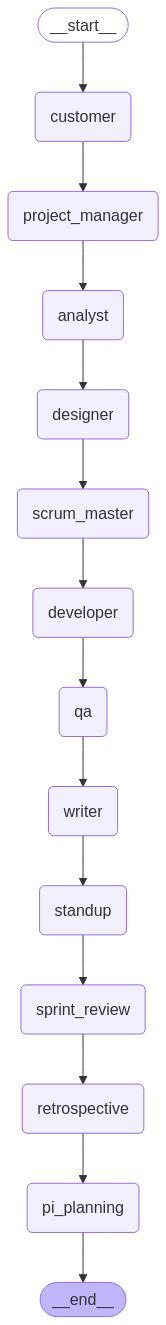

In [7]:
from IPython.display import Image, display

try:
    display(Image(scrum_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Graph rendering failed. Make sure required packages are installed.")
    print(f"Error: {e}")


In [8]:
initial_state = {
    "task": "Design a grocery-store dashboard app with real-time analytics",
    "logs": [],
    "pi_table": "",
    "start_date": start_date.strftime("%Y-%m-%d"),
    "end_date": end_date.strftime("%Y-%m-%d")
}

final_state = {}
for step in scrum_graph.stream(initial_state):
    for _, out in step.items():
        final_state = out


In [9]:
def colored(role, text):
    colors = {
        "Customer": "\033[94m",           # Blue
        "Project Manager": "\033[96m",    # Cyan
        "Business Analyst": "\033[92m",   # Green
        "UI/UX Designer": "\033[95m",     # Magenta
        "Scrum Master": "\033[93m",       # Yellow
        "Developer": "\033[91m",          # Red
        "QA Engineer": "\033[90m",        # Gray
        "Technical Writer": "\033[38;5;208m",  # Orange
        "Stand-up": "\033[33m",           # Yellow
        "Sprint Review": "\033[36m",      # Cyan
        "Retrospective": "\033[35m",      # Purple
        "PI Planning": "\033[1;32m",      # Bright Green
    }
    reset = "\033[0m"
    return f"{colors.get(role, '')}{text}{reset}"

print("\nCONVERSATION LOG:")
for log in final_state["logs"]:
    for role in [
        "Customer", "Project Manager", "Business Analyst", "UI/UX Designer",
        "Scrum Master", "Developer", "QA Engineer", "Technical Writer"
    ]:
        if log.startswith(f"[{role}]"):
            _, content = log.split("]:", 1)
            print(colored(role, f"\n[{role}]:\n{clean_log(content.strip())}"))


CONVERSATION LOG:

[Customer]:
**Business Goals & Success Metrics**

Our goal is to create a comprehensive grocery store dashboard app that provides real-time analytics to inform business decisions, improve operational efficiency, and enhance customer experience.

Success metrics:

1. **Revenue Growth**: Increase sales by 10% within the first six months of implementing the dashboard.
2. **Operational Efficiency**: Reduce inventory turnover time by 20% through optimized stock management and supply chain optimization.
3. **Customer Satisfaction**: Improve customer satisfaction ratings by 15% through data-driven insights on product demand, pricing, and promotions.
4. **Employee Productivity**: Increase employee productivity by 12% through streamlined processes and real-time visibility into sales performance.

**Primary User Scenarios**

1. **Store Manager**:
	* View daily sales reports and compare to previous years.
	* Monitor inventory levels and receive alerts for low stock.
	* Analyze

In [10]:
print("\nSTANDUP + REVIEW + RETRO:")
for role in ["Stand-up", "Sprint Review", "Retrospective"]:
    for log in final_state["logs"]:
        if log.startswith(f"[{role}]"):
            _, content = log.split("]:", 1)
            print(colored(role, f"\n[{role}]:\n{clean_log(content.strip())}"))



STANDUP + REVIEW + RETRO:

[Stand-up]:
**Daily Stand-up Summary**

**Yesterday's Work**
We made good progress on designing the grocery-store dashboard app. We focused on creating a user-friendly interface and setting up the basic layout of the app. We also started working on integrating real-time analytics, which will provide valuable insights for store managers to optimize inventory management and sales forecasting.

Specifically, we:

* Designed the home screen with key metrics such as sales, inventory levels, and customer engagement
* Created a dashboard for tracking sales trends and analyzing customer behavior
* Set up the data visualization tools for displaying real-time analytics

**Today's Plan**
Today, we'll continue working on integrating real-time analytics and exploring ways to enhance user experience. Our goals are:

* Implement a data pipeline to collect and process sales data from various sources (e.g., POS systems, inventory management software)
* Develop a data visuali

In [11]:
print(colored("PI Planning", "\n📊 PI PLANNING TABLE:"))
print(final_state.get("pi_table", "No PI planning data available."))


📊 PI PLANNING TABLE:
**Project Plan: Grocery Store Dashboard App with Real-Time Analytics**

### Project Objectives

| **Objective** | **Description** |
| --- | --- |
| 1. Develop a user-friendly dashboard for real-time analytics of grocery store sales and inventory levels. | The app should provide an intuitive interface for users to view sales data, inventory levels, and other relevant metrics in real-time. |
| 2. Integrate with existing systems for seamless data synchronization. | The app should be able to connect with the company's existing inventory management system, point-of-sale system, and other relevant software to ensure accurate and up-to-date data. |
| 3. Implement data visualization and reporting features. | The app should include interactive charts, graphs, and reports to help users quickly identify trends and patterns in sales data and inventory levels. |

### Project Team

| **Team Member** | **Role** | **Duration (weeks)** |
| --- | --- | --- |
| John Doe | Project Ma